In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
# Load the CSV file
df = pd.read_excel('retail_data.xlsx')

# Display first few rows
df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID

# Remove cancellations (negative quantities)
df = df[df['Quantity'] > 0]

# Calculate total spending per transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate data by CustomerID for clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4339, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


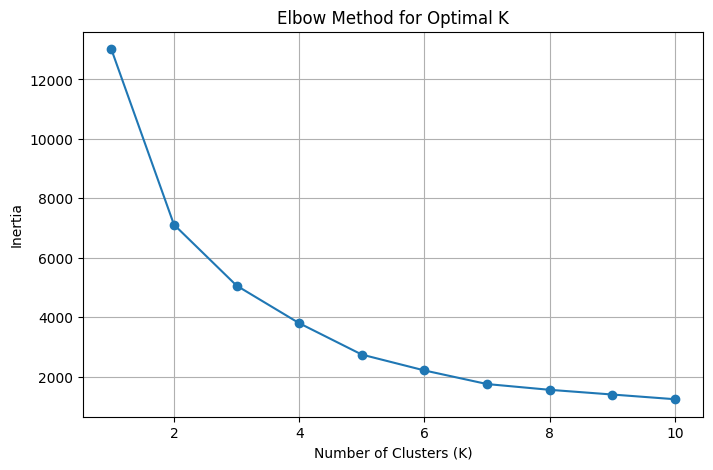

In [8]:
# Elbow method to determine optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Cluster Summary:
          TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.754411   5.094466         1.719604
1          7.720393   7.192450         6.968750
2         10.832794  10.250439        77.545455


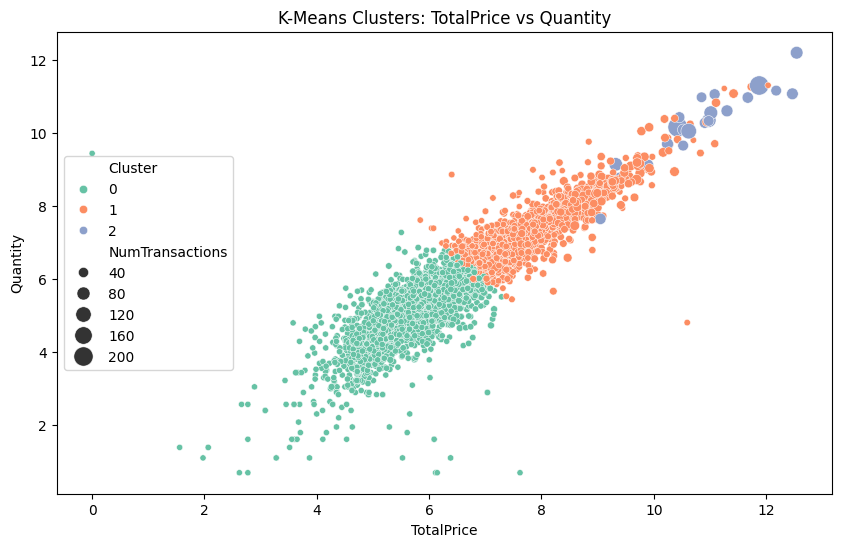

In [9]:
# Apply K-Means with optimal K (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = customer_data.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', size='NumTransactions',
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('K-Means Clusters: TotalPrice vs Quantity')
plt.show()

Number of clusters (excluding noise): 4
Noise points (Cluster -1): 60


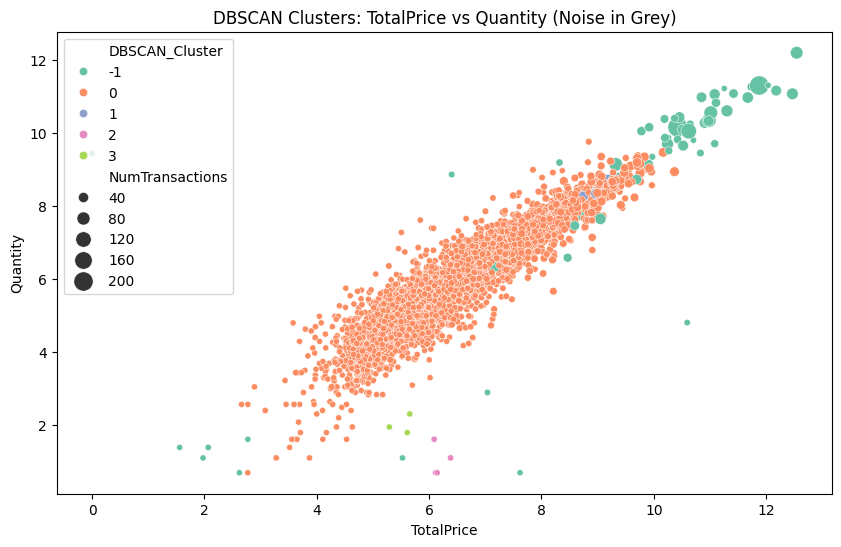

In [10]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples may need tuning
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
print("Number of clusters (excluding noise):", len(set(customer_data['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_data['DBSCAN_Cluster'] == -1).sum())

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', size='NumTransactions',
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('DBSCAN Clusters: TotalPrice vs Quantity (Noise in Grey)')
plt.show()


K-Means Cluster Counts:
 Cluster
0    2525
1    1792
2      22
Name: count, dtype: int64

DBSCAN Cluster Counts:
 DBSCAN_Cluster
 0    4266
-1      60
 1       5
 2       5
 3       3
Name: count, dtype: int64


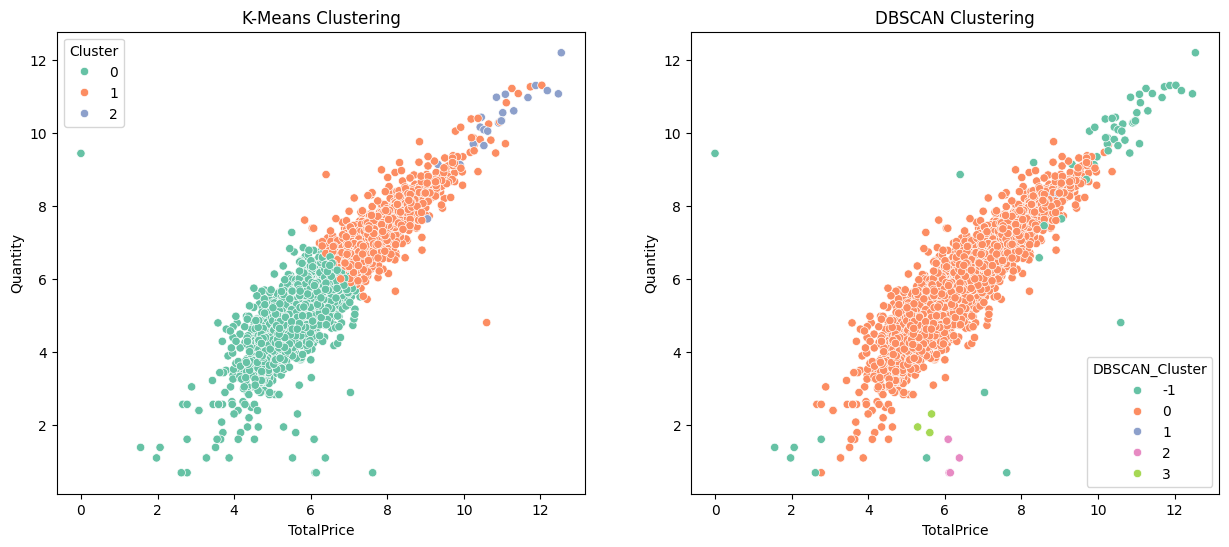

In [11]:
print("\nK-Means Cluster Counts:\n", customer_data['Cluster'].value_counts())
print("\nDBSCAN Cluster Counts:\n", customer_data['DBSCAN_Cluster'].value_counts())

# Visualize side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', data=customer_data,
                palette='Set2', ax=ax1)
ax1.set_title('K-Means Clustering')
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', data=customer_data,
                palette='Set2', ax=ax2)
ax2.set_title('DBSCAN Clustering')
plt.show()

**Insights from the Clustering Comparison (K-Means vs. DBSCAN)**
1. **K-Means Clustering (Left Plot)**
The dataset is divided into three clusters (0, 1, and 2).
The clusters show a clear separation along the TotalPrice and Quantity dimensions.
Customers with higher total spending and quantity purchased are grouped together.
There is no identification of outliers, as K-Means assigns every data point to a cluster.
2. **DBSCAN Clustering (Right Plot)**
DBSCAN identifies four clusters (0, 1, 2, and 3), plus noise points (-1 in green).
The majority of customers are grouped into a single dense cluster (orange, cluster 0).
DBSCAN detects outliers (green points, labeled as -1) that don't fit well into any cluster.
Some customers are categorized into smaller clusters (purple, pink, and green dots).
Comparison of K-Means vs. DBSCAN
Feature	K-Means	DBSCAN
Clusters	Clearly defined, equal-sized clusters	Density-based, variable-sized clusters
Outliers	No detection	Identifies noise (-1)
Shape of Clusters	Spherical	Arbitrary shapes
Best Use Case	Well-separated clusters	Data with outliers or non-uniform densities
